In [43]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [44]:
application_test = pd.read_csv("data/application_test.csv", nrows=1000, encoding='latin')
application_train = pd.read_csv("data/application_train.csv", nrows=1000, encoding='latin')
bureau_balance = pd.read_csv("data/bureau_balance.csv", nrows=1000, encoding='latin')
bureau = pd.read_csv("data/bureau.csv", nrows=1000, encoding='latin')
cc = pd.read_csv("data/credit_card_balance.csv", nrows=1000, encoding='latin')
HomeCredit_col_desc = pd.read_csv("data/HomeCredit_columns_description.csv", nrows=1000, encoding='latin')
ins = pd.read_csv("data/installments_payments.csv", nrows=1000, encoding='latin')
pos = pd.read_csv("data/POS_CASH_balance.csv", nrows=1000, encoding='latin')
previous = pd.read_csv("data/previous_application.csv", nrows=1000, encoding='latin')
sample = pd.read_csv("data/sample_submission.csv", nrows=1000, encoding='latin')

In [45]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

##### application train test

In [46]:
application = pd.concat([application_train, application_test]).reset_index()
application = application[application['CODE_GENDER'] != 'XNA']

nan_as_category = False
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    application[bin_feature], uniques = pd.factorize(application[bin_feature])
    # Categorical features with One-Hot encode
application, cat_cols = one_hot_encoder(application, nan_as_category)

# NaN values for DAYS_EMPLOYED: 365.243 -> nan
application['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
# Some simple new features (percentages)
application['DAYS_EMPLOYED_PERC'] = application['DAYS_EMPLOYED'] / application['DAYS_BIRTH']
application['INCOME_CREDIT_PERC'] = application['AMT_INCOME_TOTAL'] / application['AMT_CREDIT']
application['INCOME_PER_PERSON'] = application['AMT_INCOME_TOTAL'] / application['CNT_FAM_MEMBERS']
application['ANNUITY_INCOME_PERC'] = application['AMT_ANNUITY'] / application['AMT_INCOME_TOTAL']
application['PAYMENT_RATE'] = application['AMT_ANNUITY'] / application['AMT_CREDIT']

##### bureau and balance

In [47]:
bureau_balance.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

In [48]:
bureau_balance, bureau_balance_cat = one_hot_encoder(bureau_balance, nan_as_category=True)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True) 
bureau_balance_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bureau_balance_cat:
    bureau_balance_aggregations[col] = ['mean']
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_aggregations)
bureau_balance_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_balance_agg.columns.tolist()])


In [49]:
bureau_balance_agg.shape

(43, 9)

In [50]:
bureau.shape

(1000, 26)

In [51]:
bureau_balance_agg.columns, bureau.columns

(Index(['MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE',
        'STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_C_MEAN',
        'STATUS_X_MEAN', 'STATUS_nan_MEAN'],
       dtype='object'),
 Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
        'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
        'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
        'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
        'AMT_ANNUITY', 'CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Closed',
        'CREDIT_ACTIVE_Sold', 'CREDIT_ACTIVE_nan', 'CREDIT_CURRENCY_currency 1',
        'CREDIT_CURRENCY_nan', 'CREDIT_TYPE_Car loan',
        'CREDIT_TYPE_Consumer credit', 'CREDIT_TYPE_Credit card',
        'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mortgage', 'CREDIT_TYPE_nan'],
       dtype='object'))

In [52]:
bureau_balance_agg.index.name

'SK_ID_BUREAU'

In [53]:
bureau = bureau.join(bureau_balance_agg, on="SK_ID_BUREAU", how='left', lsuffix='', rsuffix='')#, on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

gc.collect()

# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: 
    cat_aggregations[cat] = ['mean']
for cat in bureau_balance_cat: 
    cat_aggregations[cat + "_MEAN"] = ['mean']


In [54]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [55]:
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()

0

In [56]:
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
gc.collect()

0

##### Previous_applications

In [57]:
previous, cat_cols = one_hot_encoder(previous, nan_as_category= True)
# if Days == 365.243  -> nan : Pourquoi?
previous['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
previous['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
previous['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
previous['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
previous['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# Add feature: value ask / value received percentage
previous['APP_CREDIT_PERC'] = previous['AMT_APPLICATION'] / previous['AMT_CREDIT']
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = previous.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
# Previous Applications: Approved Applications - only numerical features
approved = previous[previous['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
# Previous Applications: Refused Applications - only numerical features
refused = previous[previous['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
del refused, refused_agg, approved, approved_agg
gc.collect()

0

##### pos_cash

In [58]:
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
gc.collect()

0

##### Installments_payments

In [59]:
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
gc.collect()

0

##### credit card balance

In [60]:
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
# General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
gc.collect()

0

##### kfold lightgbm
LightGBM GBDT with KFold or Stratified KFold  
Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

In [61]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import re

def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}")
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        #print(f"train_x: {train_x}, train_y: {train_y}, eval_set={[(train_x, train_y), (valid_x, valid_y)]}")
        #print(f"train_x: {train_x.columns}, train_y : {train_y.tolist()}")
        #print(f"valid_x : {valid_x.columns}, valid_y : {valid_y.tolist()}")
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose=200, early_stopping_rounds = 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        print(f"fold_importance_df: {clf.feature_importances_}")
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv("simulation_results.csv", index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

##### Affichage de l'importance des features

In [62]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [63]:
df = application.copy()
df.merge(bureau_agg, how='left', on="SK_ID_CURR")
df.merge(previous, how='left', on="SK_ID_CURR")
df.merge(pos, how='left', on="SK_ID_CURR")
df.merge(ins, how='left', on="SK_ID_CURR")
df.merge(cc_agg, how='left', on="SK_ID_CURR")

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,995,106851,NaN,0,1,0,0,297000.0,790830.0,52978.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,996,106852,NaN,0,0,0,2,225000.0,177768.0,14175.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,997,106853,NaN,0,1,1,0,202500.0,479700.0,49153.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,998,106854,NaN,1,0,0,0,202500.0,574402.5,29457.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
df.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623


In [72]:
df.shape

(2000, 235)

In [71]:
df["TARGET"].value_counts()

0.0    930
1.0     70
Name: TARGET, dtype: int64

#todo : supprimer les anciens df qui ont servie à la création du df final
il ne faut pas considérer la partie de test
regarder pour garder les fonctions.
utiliser toutes les lignes de tous le dataset pour sauvegarder le data set final.
REgarder le taux de remplissage des colonnes et supprimer les colonnes qui ne sont pas assez remplies.
checker les valeurs infinies et les remplacer par des nan.
Regarder comment remplacer les valeurs manquante ( médiane de la colonne)
REgarder les techniques de feature selection : permet de détecter les features qui comptent pour la valeur de la target. LE feature importance est une technique de feature selection. Il y a aussi le k-best feature, rfe (dans scikite learn. On lui donne l'estimateur et le nombre de features qu'on veut à la fin).
Choisir les features validées par au moins trois des précédentes approches. 
notebook d'expolication : https://www.kaggle.com/code/sz8416/6-ways-for-feature-selection/notebook
Puis faire ce qu'on appelle un équilibrage des classes. LE faire avec la librairie SMOTE (technique d'oversampling : il va augmenter la classe minoritaire en créant des lignes fivtives qui ont le mêm comportement que la classe minoritaire).

On peut faire une rapide analyse exploratoire (pas obligé)

A partir de la on peut commencer l'entrainement des différents modèles.
Le scoring est en fait une problématique de classification binaire donc d'algorithmes supervisés
La metric sera pas l'accuracy car non adapté : il faut être très attentif sur les faux négatifs (ceux à qui ont donne de l'argent alors qu'ils ne peuvent pas rembourser) Il faut utiliser le roc auc (bien comprendre comment ça marche)
Bien comprendre la matrice de confusion pour savoir lesquels des cas on va favoriser. 
 Vérifier le nombre de colonnes (on est sensé avoir 700 colonnes au total alors que là on en a 235)

Starting LightGBM. Train shape: (1000, 235), test shape: (1000, 235)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.5	training's binary_logloss: 0.367786	valid_1's auc: 0.5	valid_1's binary_logloss: 0.367786
fold_importance_df: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Fold  1 AUC : 0.500000
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.5	training's binary_logloss: 0.360609	valid_1's au

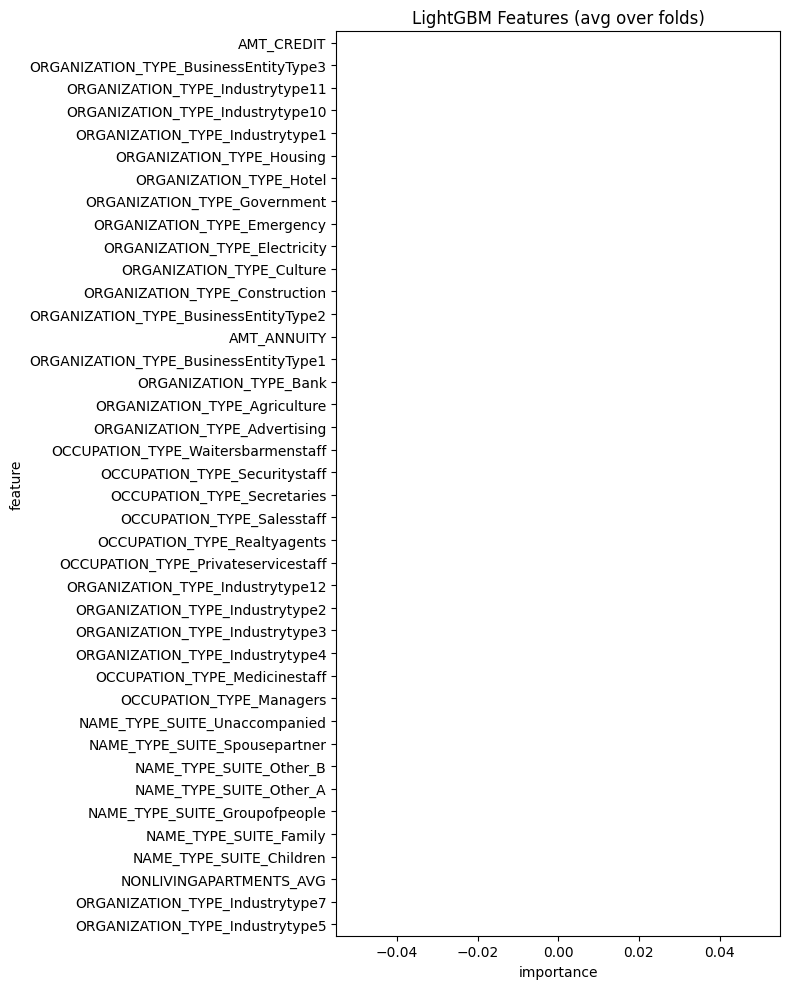

In [64]:
feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False)

In [81]:
feat_importance.head()

,feature,importance,fold
0,CODE_GENDER,0,1
1,FLAG_OWN_CAR,0,1
2,FLAG_OWN_REALTY,0,1
3,CNT_CHILDREN,0,1
4,AMT_INCOME_TOTAL,0,1
